In [38]:
import torch

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

## GPT Model

### Pipeline Usage

In [3]:
gpt = pipeline('text-generation', model='openai-gpt')

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

In [25]:
prompt = "Once upon a time, there was a mad king"
answer = gpt(prompt, max_length=30)
print(answer[0]["generated_text"])

Once upon a time, there was a mad king whose greatest hope was victory over the weak. and so, the tyrant was the king of the north


### Importing the model as Classifier and the tokenizer

In [39]:
tokenizer = AutoTokenizer.from_pretrained("openai-gpt")
model = AutoModelForSequenceClassification.from_pretrained("openai-gpt")

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Adding a pad token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Set the pad_token_id in the model configuration
model.config.pad_token_id = tokenizer.pad_token_id

# Make sure the model is aware of the new tokens
model.resize_token_embeddings(len(tokenizer))

Embedding(40479, 768)

In [44]:
inputs = tokenizer("Hello, I'm testing the first gpt", return_tensors="pt")
inputs

{'input_ids': tensor([[3570,  240,  249,  256,  258, 8448,  481,  929,   30, 1992]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [45]:
inputs = tokenizer("Hello, I'm testing the first gpt", return_tensors="pt")
outputs = model(**inputs)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.5535, -0.0586]], grad_fn=<IndexBackward0>), hidden_states=None, attentions=None)

In [46]:
prediction = torch.argmax(outputs.logits)
prediction

tensor(0)

## SST-2 Dataset

In [27]:
dataset = load_dataset("sst2")
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [35]:
print(dataset["train"]["sentence"][120])
print(dataset["train"]["label"][120])

very well-written and very well-acted . 
1


In [36]:
# Prepare the torch dataloader
train_dataloader = torch.utils.data.DataLoader(dataset=dataset['train'], batch_size=32)
eval_dataloader = torch.utils.data.DataLoader(dataset=dataset['validation'], batch_size=32)

## Finetuning

In [47]:
num_epochs = 2
num_training_steps = 3 * len(train_dataloader) # training_steps is # of gradient updates

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01) # weight decay is the penalization parameter
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
# Log the loss values
train_set_loss_log = []
validation_set_loss_log = []

for epoch in range(num_epochs):
    print(epoch)
    # Training mode on
    model.train()
    total_train_loss = 0.0

    for batch in tqdm(train_dataloader):

        inputs = tokenizer(batch['sentence'], padding=True, truncation=True, return_tensors='pt')
        labels = batch['label']
        output = model(**inputs, labels=labels)
        
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()

        lr_scheduler.step()

        total_train_loss += output.loss.item()
    
    average_train_loss = total_train_loss / len(train_dataloader)
    train_set_loss_log.append(average_train_loss)    
    
    # Eval mode on
    model.eval()
    total_val_loss = 0.0

    with torch.inference_mode():
        for batch in tqdm(eval_dataloader):
            # Evaluate the validation loss
            inputs = tokenizer(batch['sentence'], padding=True, truncation=True, return_tensors='pt')
            labels = batch['label']
            output = model(**inputs, labels=labels)
            
            total_val_loss += output.loss.item()

    average_val_loss = total_val_loss / len(eval_dataloader)
    validation_set_loss_log.append(average_val_loss)     

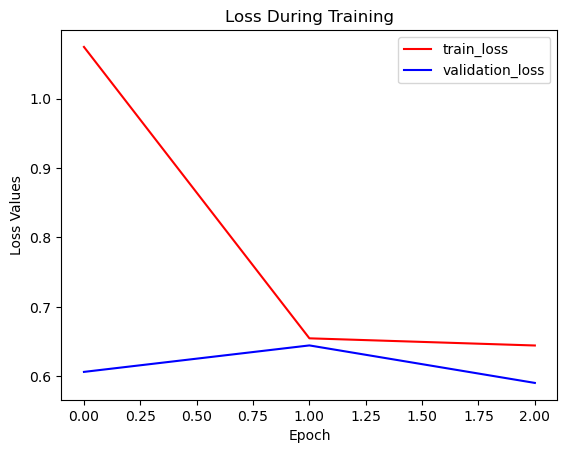

In [43]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.legend()
plt.show()